In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#RTDIP extension for weather data
from rtdip_weather import PythonHistoricalWeatherSource

## Solution Introduction

* We will build machine learning models to predict the energy consumption from 2018-12-23 to 2018-12-31. Then based on the predictions, find the best time to have the party when has the minimum party cost.
* Only focus on the scrooge building. Data of many buildings in the same area is provided. However, the buildings have unique properties such as size, age, house/apartment, etc., which will impact the energy consumption patterns greatly.
* Only focus on winter time. For the same building, the consumption patterns from different seasons are different. Learning from summer time will bring too much noise for predictions for winter time.
* Weather data will be obtained from customized RTDIP API call.

## Load data
### Load scrooge data

In [2]:
scrooge_loadprofile_path = os.getcwd()+'/data/scrooge_bldg.parquet'
meatadata_path = os.getcwd()+'/data/scrooge_metadata.parquet'

scrooge = pd.read_parquet(scrooge_loadprofile_path, engine='pyarrow')
scrooge_metadata = pd.read_parquet(meatadata_path, engine='pyarrow')

scrooge =scrooge.rename({'out.electricity.heating_hp_bkup.energy_consumption':'heating_hp',
                           'out.electricity.heating.energy_consumption':'heating',
                           'out.electricity.plug_loads.energy_consumption':'plug'}, axis=1)    

target_cols = ['heating_hp','heating','plug']
print(scrooge.shape)

(34080, 118)


### Load weather data for the scrooge location using RTDIP API

* The scrooge house is located in Boston area, where Eastern Time is used. If the time zone is specified, the RTDIP API will return data in the local time, which depends on the time the request is sent. In other words, the historical data won't be able to adjust the time based on historical daylight saving events.
* If we run the API call now (after March 10, 2024), the time returned is daylight saving time. However, winter is regular time. I have the data that requested in Jan 2024 when the time is regular time. We can verify that the data returned now and returned in Jan 2024 have just one hour difference by the following code.
* We will use the weather data the requested in Jan 2024.

In [3]:
latitude = float(scrooge_metadata['in.weather_file_latitude'].values[0])
longitude = float(scrooge_metadata['in.weather_file_longitude'].values[0])

weather_daylight_saving = PythonHistoricalWeatherSource(
        params = {
            "latitude": latitude,
        	"longitude": longitude,
            "start_date": "2018-01-01",
        	"end_date": "2018-12-31",
            "timezone": "America/New_York"
        }
    ).read_batch()

In [4]:
weather_regular_time = pd.read_csv('weather_regular_time.csv')
weather_regular_time['time'] = pd.to_datetime(weather_regular_time['time'])

The data from two queries (one in 2024 Jan, the other in 2024 March) are actually same if we adjust the one hour difference.

In [5]:
assert np.all(weather_daylight_saving['temperature'].shift(-1).dropna().values==weather_regular_time['temperature'].values[:-1])
assert np.all(weather_daylight_saving['humidity'].shift(-1).dropna().values==weather_regular_time['humidity'].values[:-1])
assert np.all(weather_daylight_saving['wind_speed'].shift(-1).dropna().values==weather_regular_time['wind_speed'].values[:-1])
assert np.all(weather_daylight_saving['pressure'].shift(-1).dropna().values==weather_regular_time['pressure'].values[:-1])

### Merge weather data

In [6]:
#merge the weather table that uses the regular time
scrooge['timestamp_hour'] = scrooge['timestamp'].dt.floor(freq='h')
scrooge = scrooge.merge(weather_regular_time, how='left', left_on='timestamp_hour', right_on='time')
print(scrooge.shape)

(34080, 125)


## Simple EDA

* Two main heating consumption highly correlate to the temperature (negative correlation). This makes sense.
* The heating_hp_bkup also depends on time. It's expected that at certain time, the heating will start if the temperature is cold. So other than the temperature, the hour will also be important feature.

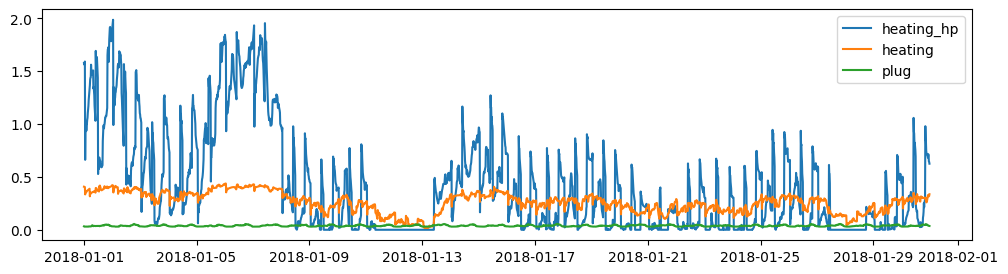

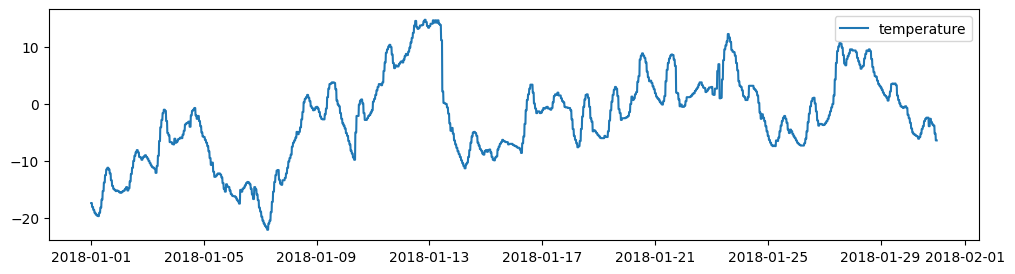

In [7]:
plot_df = scrooge[(scrooge['timestamp']>'2018-1-01') & (scrooge['timestamp']<'2018-1-31')]
plt.figure(figsize=(12,3))
for col in target_cols:
    plt.plot(plot_df['timestamp'],plot_df[col], label=col)
plt.legend(loc='upper right')
plt.show()
plt.figure(figsize=(12,3))
plt.plot(plot_df['timestamp'],plot_df['temperature'], label='temperature')
plt.legend(loc='upper right')
plt.show()

## Train ML Models

### Train targets
Train regression models, using the sum of three energy consumption as the target.

### Train data
Train the models with just the winter data. The energy consumption patterns are different for different seasons. Plus, the weather data in winter are not influenced by daylight saving, so we don't need to align the timestamps for daylight saving. 

### Pre-process and feature engineering 
There are two kinds of features: weather related like temperature and time related like hour, minute.

Simple smoothing is applied to the weather data. Because the frequency of weather data is hourly. 

### Cross-validation
Training cross-validation is 5-folds without shuffling. The data is sorted by time. Shuffling will have data leakage because adjacent observations have similar values. We don't need strict moving forward time series splits. The patterns of Dec 2018 can be used to learn for patterns of Jan 2018.

In [8]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,TimeSeriesSplit,GroupKFold
from sklearn.metrics import mean_squared_error,mean_absolute_error 
from scipy.signal import savgol_filter

In [9]:
def preprocess(df):
    """
    preprocess and feature engineering 
    Args:    
        df (DataFrame): train or test data
    Returns:
        df (DataFrame): processed train or test data        
    """

    #extract time related features 
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['weekday'] = df['timestamp'].dt.weekday

    #smoothing the weather signals (because they are collected every hour)
    for col in ['temperature', 'pressure', 'humidity', 'wind_speed']:
        df[col]  = savgol_filter(df[col], 7, 2)
        
    return df

In [10]:
def lightgbm_cv(train_df, target, features, params, n_splits = 5, random_state=42, shuffle=True, sample_weight=None, kfold = False):
    """
    LightGBM training with cross validation
    """
    models = []
    #setup the folds
    if kfold:
        folds = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    else:
        folds = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    oof = np.zeros(len(train_df))  
    fold = np.zeros(len(train_df))
    fold_scores = []    
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target)):
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target[val_idx])

        if sample_weight is not None:
            trn_data.set_weight(sample_weight[trn_idx])
            val_data.set_weight(sample_weight[val_idx])
        
        model = lgb.train(params, trn_data,valid_sets = [trn_data, val_data], verbose_eval=1000)
        
        models.append(model)
        
        oof[val_idx] = model.predict(train_df.iloc[val_idx][features], num_iteration=model.best_iteration)
        fold[val_idx] = fold_
        fold_scores.append(mean_squared_error(target[val_idx], oof[val_idx]))        
   
    return models, oof, fold_scores

In [11]:
train = scrooge[['timestamp','temperature', 'humidity', 'wind_speed', 'pressure']+target_cols].copy()
#the target is the total energy usage
train['target'] = np.sum(train[target_cols], axis=1)
train = preprocess(train)

#only train with data in winter, the daylight saving started on March 11, 2018.
train = train[(train['timestamp']<'2018-3-10') | (train['timestamp']>='2018-12-1')]
assert train['temperature'].isna().sum()==0
train = train.dropna()
print(train.shape)

(8544, 12)


In [12]:
features = [x for x in train.columns if x not in ['target','timestamp']+target_cols]
params = { 'boost': 'gbdt',  'n_estimators': 200, 'verbosity': -1, 
           'learning_rate': 0.12, 'max_depth':8,             
           'num_leaves': 25, 'min_data_in_leaf': 6, 
           'bagging_fraction': 0.5,                      
           'objective': 'regression', 'metric': 'l2', 
           'early_stopping_round': 100, 
          } 

target = train['target'].values

print(train.shape[0], len(features))
#shuffle is False, that means the splits is based on order(time)
models, oof, fold_scores = lightgbm_cv(train, target, features, n_splits = 5, 
                                       random_state=None, params=params, shuffle=False, kfold = True)      

8544 7
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's l2: 0.00223898	valid_1's l2: 0.128667
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.00157366	valid_1's l2: 0.0118574
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.00140819	valid_1's l2: 0.0155679
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.00645129	valid_1's l2: 0.0116818
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.00155905	valid_1's l2: 0.00777086


## Find the solution

* Treat the period of 2018-12-23 to 2018-12-31 as the test. Predict target (the total usage) on the test.
* Find the 2 hour window that has the minimum party cost.

In [13]:
FIXED_LOAD = 2/4 #load of 2kw in every 15 mins

def predict_test(models, features, weather):
    """
    Generate model predictions for the test period of 2018-12-23 to 2018-12-31
    Args:    
        models: trained lightgbm models
        features: model's input features 
    Returns:
        test (DataFrame): dataframe of timestamps in the test period and the predictions of each timestamp     
    """
    #generate test after 2018-12-22
    test = pd.DataFrame({'timestamp': pd.date_range(start='2018-12-23 00:00:00', 
                                                    end='2019-01-01 00:00:00',
                                                    inclusive='right', freq='15T')})

    test['timestamp_hour'] = test['timestamp'].dt.floor(freq='h')
    test = test.merge(weather, how='left', left_on='timestamp_hour', right_on='time')    
    test = preprocess(test)

    #predict target, total usage
    preds = np.zeros(len(test))    
    for model in models:  preds+= model.predict(test[features])/len(models)
        
    test['pred'] = preds    
    #rate and load are for previous 15 mins period
    test['timestamp_start'] = test['timestamp'].shift(1)

    return test

def minimize_party_cost(test):   
    """
    This function will find 2 hours window that has the minimum party cost
    Args:    
        test (DataFrame): energy consumption predictions of the test period of 2018-12-23 to 2018-12-31
    Returns:
        party_start: the time the part starts for the 2 hours window
        party_cost: the cost if the part starts at the party_start, and the cost is the minimum for all 2 hours 
        submission (DataFrame): the dataframe follows the submission format 
    """
    candidates = test[['timestamp','timestamp_start','pred']].copy()
    candidates['usage'] = 0.3 * candidates['pred'] + FIXED_LOAD
    candidates['rate'] = 0.2
    candidates.loc[(candidates['timestamp_start'].dt.hour>=18) & (candidates['timestamp_start'].dt.hour<22), 'rate'] = 0.35
    candidates['cost'] = np.round(candidates['usage'] *  candidates['rate'], 4)
    #sum of the next 16 cost including itself
    candidates['party_cost'] = candidates['cost'].rolling(16).sum().shift(-15)

    #the party must start between 17:00 and 20:00, find the index has the minimum total cost
    min_cost_idx = candidates[((candidates['timestamp_start'].dt.hour>=17) & (candidates['timestamp_start'].dt.hour<20))
                            | ((candidates['timestamp_start'].dt.hour==20) & (candidates['timestamp_start'].dt.minute==0))]['party_cost'].idxmin()    
        
    party_start, party_cost = candidates.at[min_cost_idx,'timestamp'], candidates.at[min_cost_idx,'party_cost']     

    return party_start

def generate_submission(test, party_start):    
    """
    Generate the submission file of the 2 hours window
    Args:    
        test (DataFrame): load predictions of the test period of 2018-12-23 to 2018-12-31
        party_start: the time the part starts for the 2 hours window
    Returns:
        submission (DataFrame): the dataframe follows the submission format
    """
    #get the 2 hours window with 16 timestamps
    submission = test[test['timestamp']>=party_start][['timestamp','timestamp_start','pred']].head(16)
    #the usage is extra load from the party plus the fixed load
    submission['usage'] =0.3*submission['pred'] + FIXED_LOAD
    submission['rate'] = 0.2
    submission.loc[(submission['timestamp_start'].dt.hour>=18) & (submission['timestamp_start'].dt.hour<22), 'rate'] = 0.35
    submission['party_cost'] = np.round(submission['usage'] *  submission['rate'], 4)
    submission = submission.reset_index(drop=True)
    #this is feedback learned from several submissions, that there will be a drop for the last 15 mins.
    submission.at[15,'party_cost']=0.1060
    
    return submission

In [14]:
test = predict_test(models, features, weather_regular_time)

start  = minimize_party_cost(test)

submission = generate_submission(test, start)

print(f"The submission's first observation is {start}, the party start time is 15 minutes earlier, the total party cost will be {submission['party_cost'].sum():.4f}.")

The submission's first observation is 2018-12-28 20:15:00, the party start time is 15 minutes earlier, the total party cost will be 2.5396.


### Submission file

In [15]:
submission[['timestamp','party_cost']].to_csv('submission.csv', index=False)
assert len(submission)==16

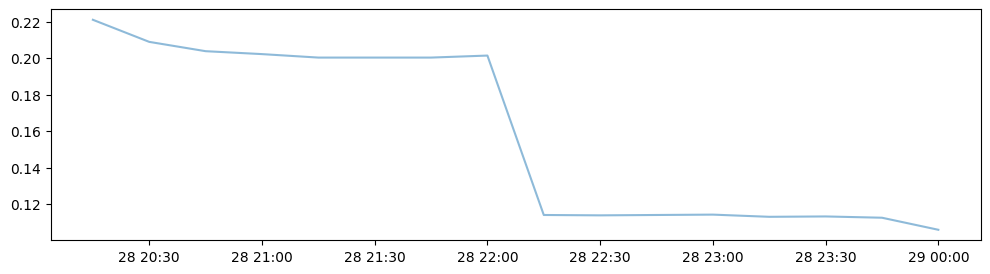

In [16]:
plt.figure(figsize=(12,3))
plt.plot(submission['timestamp'],submission['party_cost'], label='submission', alpha=0.5)
plt.show()